<a href="https://colab.research.google.com/github/VAMSI-datascience/Optimizing-Inventory-Management/blob/main/inventory_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Optimizing Inventory Management (Evaluation & Planning)**                                                                                                                                            

Problem Statement:


Context: A retail firm has many products in their inventory, and very few of them tend to sell (only about 10% sell each year) and many of the products only have a single sale in the course of a year

Objective: The sales and growth team of the retail firm wants to determine which products from their inventory should they retain to sell and the ones to discard

Data: The data given contains both historical sales data AND active inventory

Goal: We have a to building a binary classifier which gives us a list of product ID which need to retained in the inventory or list of products that need to be removed

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

# loading important modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *
from imblearn.over_sampling import SMOTE
import itertools

%matplotlib inline
matplotlib.style.use('ggplot')
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


['SalesKaggle3.csv']


In [ ]:
# Reading the dataset
sales_data = pd.read_csv("../input/SalesKaggle3.csv")

In [ ]:
# Gist of the dataset
sales_data.head()

Order   File_Type     ...       LowUserPrice  LowNetPrice
0      2  Historical     ...              28.97        31.84
1      3  Historical     ...               0.00        15.54
2      4  Historical     ...              30.19        27.97
3      6  Historical     ...             133.93        83.15
4      7  Historical     ...               4.00        23.99

[5 rows x 14 columns]

In [ ]:
#Statistical description of the dataset
sales_data.describe()

Order    SKU_number      ...         LowUserPrice    LowNetPrice
count  198917.000000  1.989170e+05      ...        198917.000000  198917.000000
mean   106483.543242  8.613626e+05      ...            30.982487      46.832053
std     60136.716784  8.699794e+05      ...            69.066155     128.513236
min         2.000000  5.000100e+04      ...             0.000000       0.000000
25%     55665.000000  2.172520e+05      ...             4.910000      17.950000
50%    108569.000000  6.122080e+05      ...            16.080000      33.980000
75%    158298.000000  9.047510e+05      ...            40.240000      55.490000
max    208027.000000  3.960788e+06      ...         14140.210000   19138.790000

[8 rows x 12 columns]

In [ ]:
# Includes categorical variable 
sales_data.describe(include='all')

Order File_Type      ...         LowUserPrice    LowNetPrice
count   198917.000000    198917      ...        198917.000000  198917.000000
unique            NaN         2      ...                  NaN            NaN
top               NaN    Active      ...                  NaN            NaN
freq              NaN    122921      ...                  NaN            NaN
mean    106483.543242       NaN      ...            30.982487      46.832053
std      60136.716784       NaN      ...            69.066155     128.513236
min          2.000000       NaN      ...             0.000000       0.000000
25%      55665.000000       NaN      ...             4.910000      17.950000
50%     108569.000000       NaN      ...            16.080000      33.980000
75%     158298.000000       NaN      ...            40.240000      55.490000
max     208027.000000       NaN      ...         14140.210000   19138.790000

[11 rows x 14 columns]

In [ ]:
# Basic questions about the dataset

# 1. Number of enteries 
print(sales_data.shape)
# We have 198917 rows and 14 columns 

# 2. Total number of products & unique values of the columns 
print("*****************")
print(sales_data.nunique())

# 3. Count of the historical and active state 
print("*****************")
print(sales_data[sales_data['File_Type'] == 'Historical']['SKU_number'].count())
print(sales_data[sales_data['File_Type'] == 'Active']['SKU_number'].count())

# 3.1 Split the dataset into two parts based on the file_type 
sales_data_hist = sales_data[sales_data['File_Type'] == 'Historical']
sales_data_act = sales_data[sales_data['File_Type'] == 'Active']

(198917, 14)
*****************
Order               198917
File_Type                2
SKU_number          133360
SoldFlag                 2
SoldCount               37
MarketingType            2
ReleaseNumber           71
New_Release_Flag         2
StrengthFactor      197424
PriceReg             11627
ReleaseYear             85
ItemCount              501
LowUserPrice         12102
LowNetPrice          15403
dtype: int64
*****************
75996
122921


Note: We will be using the historical dataset for the analysis and training the model
Univariate distribution plots
This section shows a frequency histogram for the selected variable along with the density and normal curves for the data

The box plot shows the basic statistics of the data like median, 25th and 75th quantiles and the outliers.

Categorical Variable
Shows the frequency distribution of the difference factors

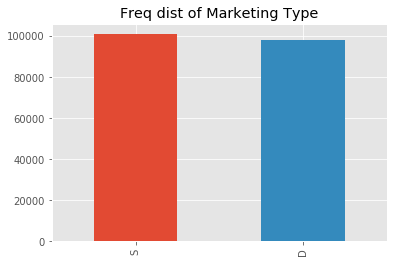

In [ ]:
sales_data['MarketingType'].value_counts().plot.bar(title="Freq dist of Marketing Type")

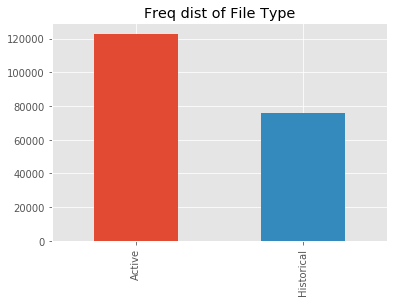

In [ ]:
sales_data['File_Type'].value_counts().plot.bar(title="Freq dist of File Type")

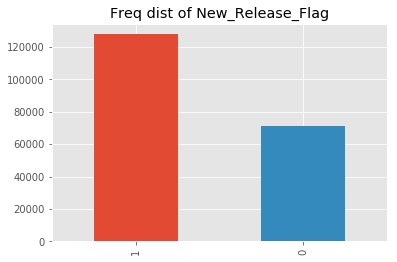

In [ ]:
sales_data['New_Release_Flag'].value_counts().plot.bar(title="Freq dist of New_Release_Flag")

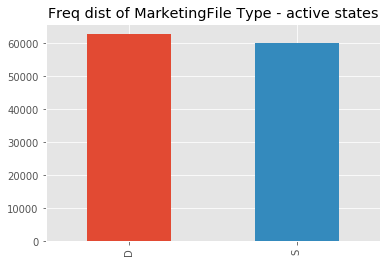

In [ ]:
sales_data_act['MarketingType'].value_counts().plot.bar(title="Freq dist of MarketingFile Type - active states")

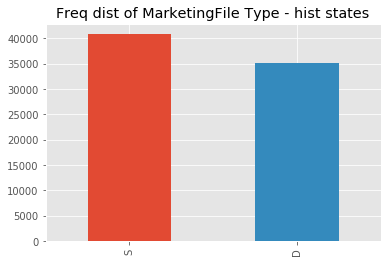

In [ ]:
sales_data_hist['MarketingType'].value_counts().plot.bar(title="Freq dist of MarketingFile Type - hist states")

Numeric Variable
Plots with a kernel density estimate and histogram with bin size determined automatically

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


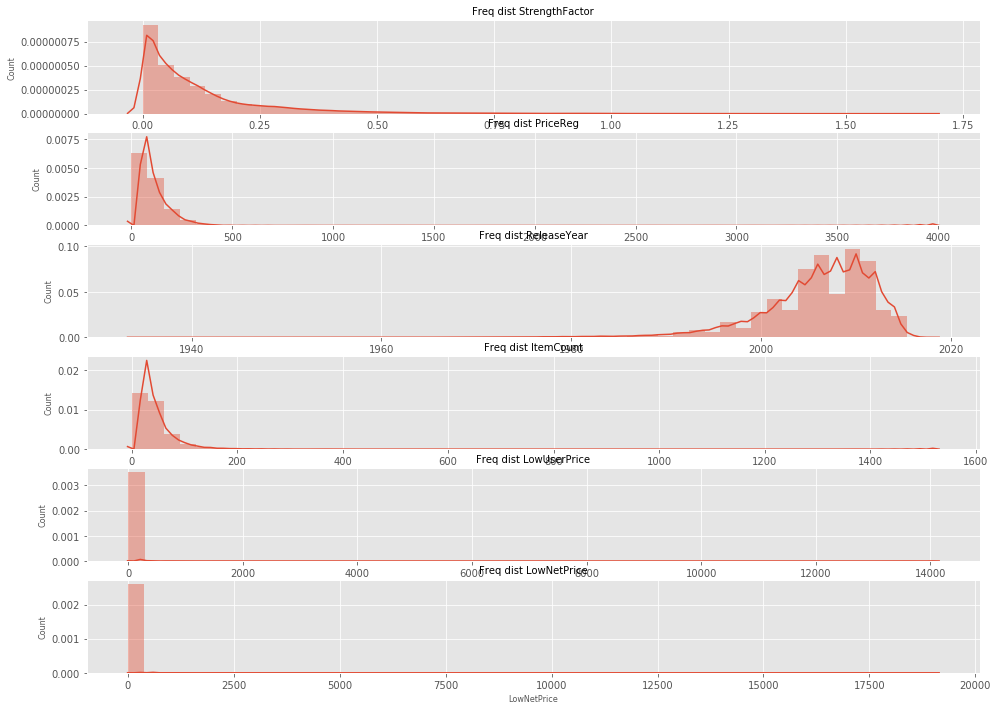

In [ ]:
col_names = ['StrengthFactor','PriceReg', 'ReleaseYear', 'ItemCount', 'LowUserPrice', 'LowNetPrice']

fig, ax = plt.subplots(len(col_names), figsize=(16,12))

for i, col_val in enumerate(col_names):
        
    sns.distplot(sales_data_hist[col_val], hist=True, ax=ax[i])
    ax[i].set_title('Freq dist '+col_val, fontsize=10)
    ax[i].set_xlabel(col_val, fontsize=8)
    ax[i].set_ylabel('Count', fontsize=8)
    
plt.show()

Univariate outlier detection
To analysis the outliers in the numeric features of the dataset

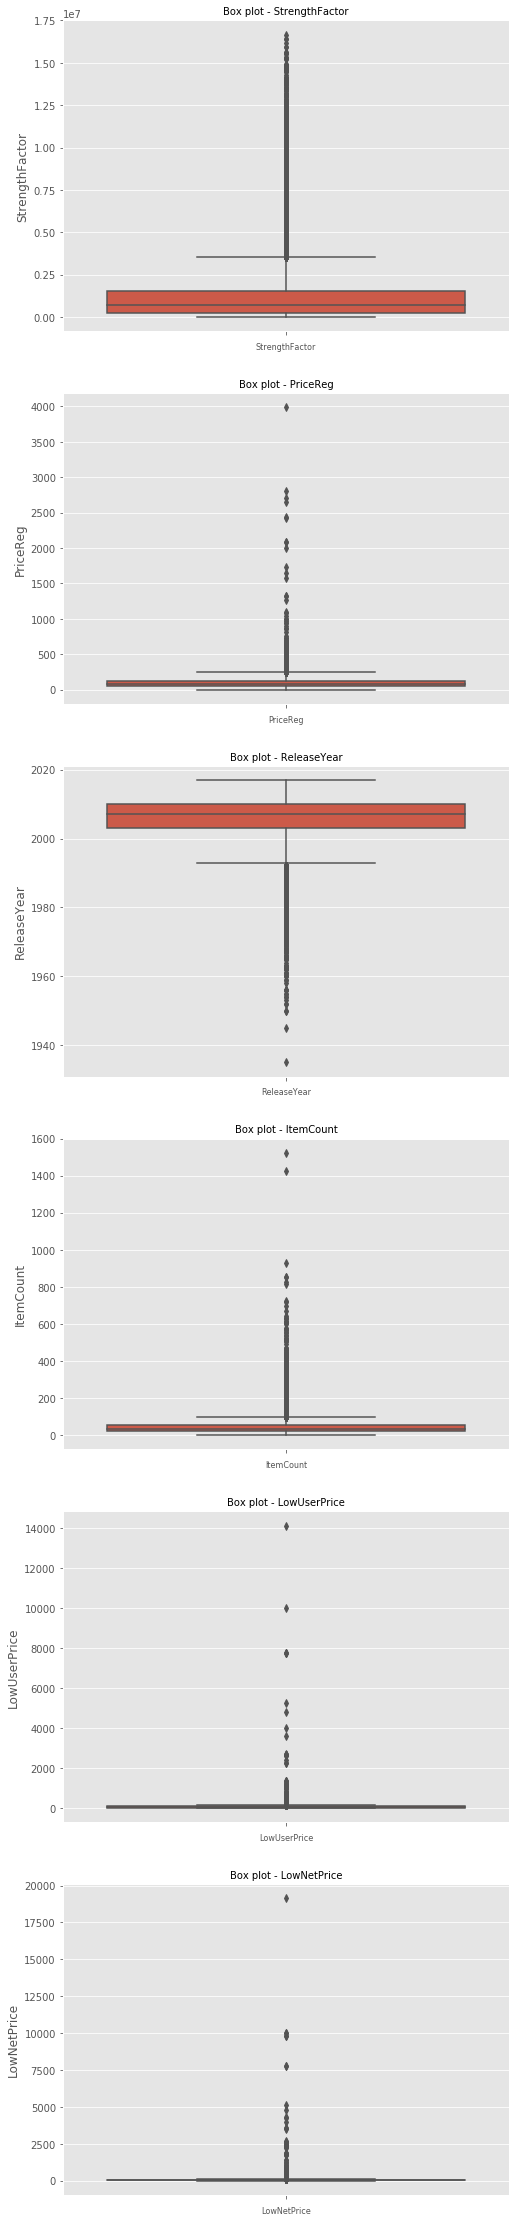

In [ ]:
col_names = ['StrengthFactor','PriceReg', 'ReleaseYear', 'ItemCount', 'LowUserPrice', 'LowNetPrice']

fig, ax = plt.subplots(len(col_names), figsize=(8,40))

for i, col_val in enumerate(col_names):
        
    sns.boxplot(y=sales_data_hist[col_val], ax=ax[i])
    ax[i].set_title('Box plot - '+col_val, fontsize=10)
    ax[i].set_xlabel(col_val, fontsize=8)
    
plt.show()

Univariate Outlier treatment
Many algorithms are sensitive to the range and distribution of attribute values in the input data. Outliers in input data can skew and mislead the results and make results less reliable, that's why we have to recognize all the outliers and treat them.

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


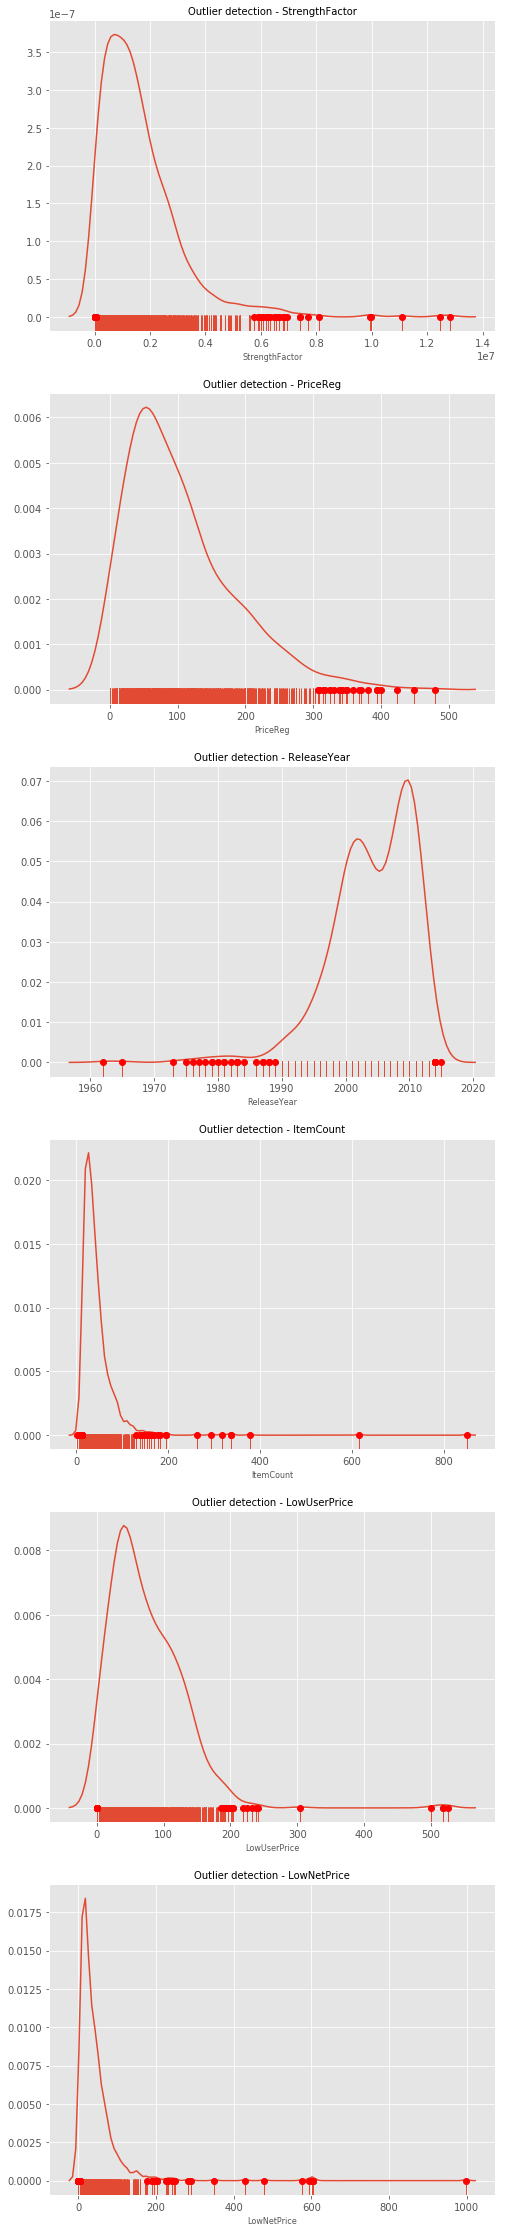

In [ ]:
# Percentile based outlier removal 
def percentile_based_outlier(data, threshold=95):
    diff = (100 - threshold) / 2.0
    minval, maxval = np.percentile(data, [diff, 100 - diff])
    return (data < minval) | (data > maxval)

col_names = ['StrengthFactor','PriceReg', 'ReleaseYear', 'ItemCount', 'LowUserPrice', 'LowNetPrice']

fig, ax = plt.subplots(len(col_names), figsize=(8,40))

for i, col_val in enumerate(col_names):
    x = sales_data_hist[col_val][:1000]
    sns.distplot(x, ax=ax[i], rug=True, hist=False)
    outliers = x[percentile_based_outlier(x)]
    ax[i].plot(outliers, np.zeros_like(outliers), 'ro', clip_on=False)

    ax[i].set_title('Outlier detection - '+col_val, fontsize=10)
    ax[i].set_xlabel(col_val, fontsize=8)
    
plt.show()

Predictive Modelling
The classification module predicts the SKU which needs to kept in the inventory (Active state)

In [ ]:
# Converting maarketing type to categorical variable 
sales_data['MarketingType'] = sales_data['MarketingType'].astype('category')
sales_data['MarketingType'] = sales_data['MarketingType'].cat.codes

# Splitting the historical and active state
sales_data_hist = sales_data[sales_data['File_Type'] == 'Historical']
sales_data_act = sales_data[sales_data['File_Type'] == 'Active']

In [ ]:
# Columns to remove 
remove_col_val = ['Order', 'File_Type', 'SKU_number', 'SoldCount', 'ReleaseNumber', 'SoldFlag']

y = sales_data_hist['SoldFlag']

sales_data_hist = sales_data_hist.drop(remove_col_val, axis=1)
sales_data_act = sales_data_act.drop(remove_col_val, axis=1)

# create training and testing vars
training_features, testing_features, training_target, testing_target = train_test_split(sales_data_hist, y, test_size=0.2)
print(training_features.shape, training_target.shape)
print(testing_features.shape, testing_target.shape)

(60796, 8) (60796,)
(15200, 8) (15200,)


In [ ]:
print("Class 0 numbers: " , len(training_target[training_target==0.0]))
print("Class 1 numbers: " , len(training_target[training_target==1.0]))

Class 0 numbers:  50445
Class 1 numbers:  10351


In [ ]:
x_train, x_val, y_train, y_val = train_test_split(training_features, training_target,
                                                  test_size = .1,
                                                  random_state=12)

In [ ]:
# Balancing the classes using SMOTE
sm = SMOTE(random_state=12, ratio = 1.0)
x_train_res, y_train_res = sm.fit_sample(x_train, y_train)

print("Class 0 numbers: " , len(y_train_res[y_train_res==0.0]))
print("Class 1 numbers: " , len(y_train_res[y_train_res==1.0]))

Class 0 numbers:  45419
Class 1 numbers:  45419


In [ ]:
clf_rf = RandomForestClassifier(n_estimators=25, random_state=12)
clf_rf.fit(x_train_res, y_train_res)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=None,
            oob_score=False, random_state=12, verbose=0, warm_start=False)

In [ ]:
print('Validation Results')
print(clf_rf.score(x_val, y_val))
print(recall_score(y_val, clf_rf.predict(x_val)))

pred = clf_rf.predict(testing_features)

print('\nTest Results')
print(clf_rf.score(testing_features, testing_target))
print(recall_score(testing_target, pred))

print('\nROC AUC score')
print(roc_auc_score(testing_target, pred))

Validation Results
0.8044407894736842
0.325426944971537

Test Results
0.80375
0.34858223062381855

ROC AUC score
0.6241119038423752


Confusion Matrix

Confusion matrix, without normalization
[[11295  1260]
 [ 1723   922]]
Normalized confusion matrix
[[0.9  0.1 ]
 [0.65 0.35]]


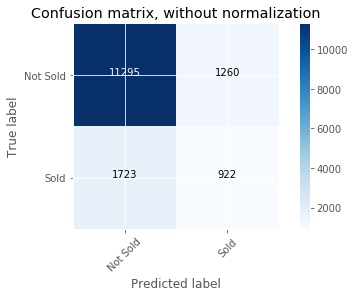

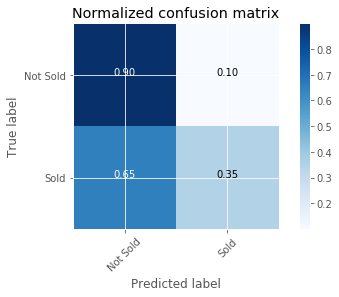

In [ ]:
class_names = ['Not Sold', 'Sold']
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(testing_target, pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

ROC

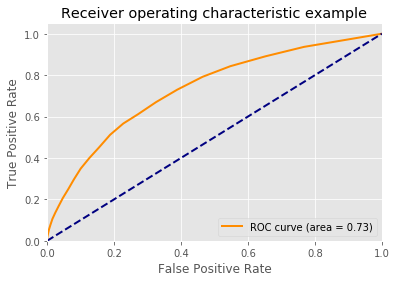

In [ ]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 2
y_score = clf_rf.predict_proba(testing_features)

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(testing_target.ravel(), y_score[:,1].ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2

plt.plot(fpr['micro'], tpr['micro'], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc['micro'])

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()